<a href="https://colab.research.google.com/github/rusonariga/peristaltic-frequency/blob/main/Peristaltic_pump_frequency_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h1 align="center"><i> Peristaltic pump frequency response </i></h1>

Script to read and process pressure input from peristaltic pump, to calculate physical parameters of inlet flow dampener design 

##<h2>Importing libraries</h2>

In [9]:
# Install needed packages
!pip install detecta

In [17]:
# Import libraries
import pandas as pd
import numpy as np
import io
import os
import matplotlib.pyplot as plt
from detecta import detect_peaks
from google.colab import files
import scipy.fftpack

##<h2>Setting the notebook</h2>

###<h3>Create folders</h3> 
Before start running the script, go to left bar and inside <code>content</code> create 2 folders with the following names:
<ul><li>data</li><li>results</li><li>figures</li></ul>

or run the following cell

In [18]:
# Required folder setting
!pwd
%cd content/
if os.path.exists('data'):
  if os.path.exists('results'):
    if os.path.exists('figures'):
      print("Set up ready to upload files")
    else:
      !mkdir figures
  else:
    !mkdir results figures
else:
  !mkdir data results figures

/content
[Errno 2] No such file or directory: 'content/'
/content
Set up ready to upload files


###<h3>Upload data</h3>
Upload datasets to <code>content/data</code> folder

In [19]:
# Upload files
%cd data
files.upload()
%cd ..
!pwd

/content/data


Saving pressure_drop_dataset.xlsx to pressure_drop_dataset.xlsx
/content
/content


###<h3>Data import from uploaded files</h3>

In [20]:
# Manual upload file and read
folder = "/content/data/"
file = "pressure_drop_dataset.xlsx"

data = pd.read_excel(folder+file)
data = data.set_index("time")

## <h2> Plots of test dataset </h2>

Here we plot raw data as received from measurements

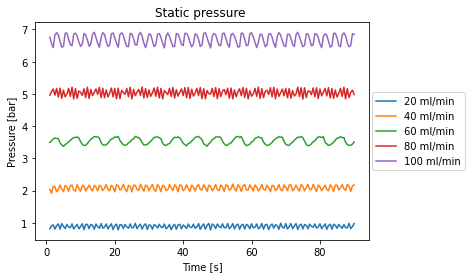

In [21]:
ax = data.plot()
ax.set_title('Static pressure ')
ax.legend(loc='center right',bbox_to_anchor=(1.3,0.5))
ax.set_xlabel("Time [s]")
ax.set_ylabel("Pressure [bar]")
plt.show()

#<h1> Frequency study</h1>

##<h2> Peak and valley detection using <code>detecta</code> library

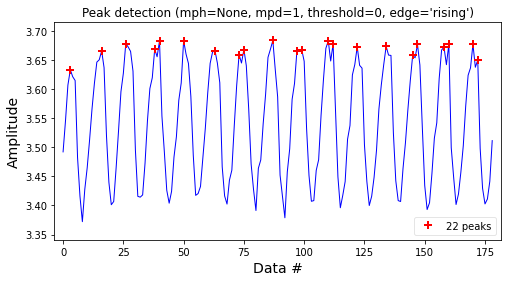

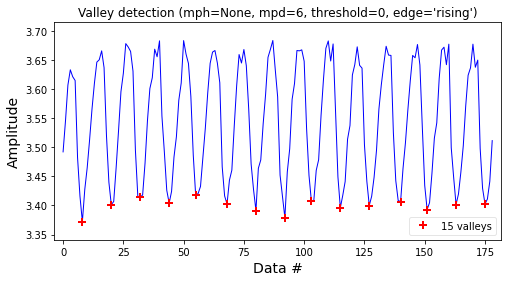

In [24]:
# Select the desired flowrate dataset to study
dataset = "60 ml/min"
values = data[dataset].values
time = data.index.values

# Detect all ALL PEAKS and plot data
peaks = detect_peaks(values,show=True)
#valleys= detect_peaks(data.to_numpy()[...,idx], mph=0.9, mpd=0.5, valley=True, show=True)

# Detect all ALL VALLEYS and plot data
valleys= detect_peaks(values,  mpd=6, valley=True, show=True)

##<h2>Find average of peaks and valleys</h2>

In [25]:
peak_avg = np.average(values[peaks])
valley_avg = np.average(values[valleys])

###<h3>Plot calculated max, min and avg</h3>

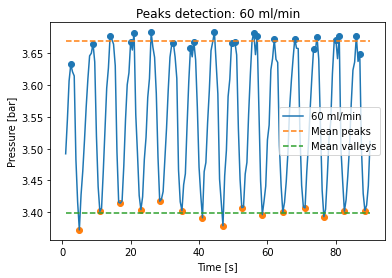

In [30]:
filename = dataset.split(" ")[0]
path = "/content/figures/"
plt.plot(time,values,label= dataset)
plt.scatter(time[peaks],values[peaks])
plt.scatter(time[valleys],values[valleys])
plt.plot(time,time*0+peak_avg, label='Mean peaks', linestyle='--')
plt.plot(time,time*0+valley_avg, label='Mean valleys', linestyle='--')
# plt.legend(loc='center right',bbox_to_anchor=(1.35,0.5))
plt.legend(loc='center right')
plt.xlabel("Time [s]")
plt.ylabel("Pressure [bar]")
plt.title(f"Peaks detection: {dataset}")
if filename != None:
  plt.savefig(f"{path}/{filename}.png", dpi=300)
plt.show()

##<h2> Calculation of the frequency</h2>

In [32]:
# Get the time values
x = data.index.values
# Get the pressure values for selected flowrate
y = data[dataset].values
# We remove the zero frequency value before performing the fourier transfor to get only the frequencies that introduce variability with the time.
y = y-y.mean()
# Size of sampling
N = x.size
# Sampling period
T = x[-1]/N

# Fourier trasnform calculation
yf = scipy.fftpack.fft(y)

# Change time values into frequency space
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

# Maximum frequency calculation
freq_max = xf[np.argmax(2.0/N * np.abs(yf[:N//2]))]

# Maximum amplitude calculation
amp_max = yf[np.argmax(2.0/N * np.abs(yf[:N//2]))]

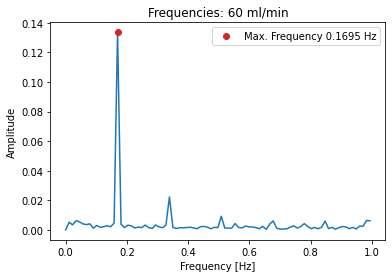

In [33]:
fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
ax.plot(freq_max, np.max(2.0/N * np.abs(yf[:N//2])), "C3o", label=f"Max. Frequency {freq_max:0.4f} Hz")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.title(f"Frequencies: {dataset}")
plt.legend()
if filename != None:
  plt.savefig(f"{path}/fft-{filename}.png", dpi=300)
plt.show()


In [35]:
# Filter frequencies smaller than 50% of the original
yf[np.abs(yf)<np.abs(yf).max()*50/100] = 0

# Fourier's transform inversion
y = scipy.fftpack.ifft(yf)

# Average is added again
y = np.real(y + data[dataset].values.mean())

##<h2>Results</h2>

In [36]:
# Create dataframe of results
results_columns=["TIME [S]","MEASURED PRESSURE [bar]","CALCULATED PRESSURE [bar]",
                "FLOWRATE [ml/min]","MAX FREQUENCY [Hz]","PERIOD [s]",
                  "MAX AMPLITUDE [bar]"]
results = pd.DataFrame(np.nan, index = np.arange(len(data.index.values)), columns=results_columns)

results["TIME [S]"] = data.index
results["MEASURED PRESSURE [bar]"] = data[dataset]
results["CALCULATED PRESSURE [bar]"] = y
results["FLOWRATE [ml/min]"][0] = dataset.split(" ")[0]           
results["MAX FREQUENCY [Hz]"][0] = freq_max
results["PERIOD [s]"][0] = 1/freq_max
results["MAX AMPLITUDE [bar]"][0] = amp_max

print(results)

# Saving results into CSV
%cd results/
results.to_csv(dataset.split(" ")[0]+".csv")
%cd ..

     TIME [S]  MEASURED PRESSURE [bar]  ...  PERIOD [s]  MAX AMPLITUDE [bar]
0         1.0                      NaN  ...    5.899441             2.450504
1         1.5                  3.49198  ...         NaN                  NaN
2         2.0                  3.60661  ...         NaN                  NaN
3         2.5                  3.62096  ...         NaN                  NaN
4         3.0                  3.48241  ...         NaN                  NaN
..        ...                      ...  ...         ...                  ...
174      88.0                      NaN  ...         NaN                  NaN
175      88.5                      NaN  ...         NaN                  NaN
176      89.0                      NaN  ...         NaN                  NaN
177      89.5                      NaN  ...         NaN                  NaN
178      90.0                      NaN  ...         NaN                  NaN

[179 rows x 7 columns]
/content/results
/content


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1036: ComplexWarning: Casting complex values to real discards the imaginary part
  self._values[loc] = value


###<h3>Plot results</h3>

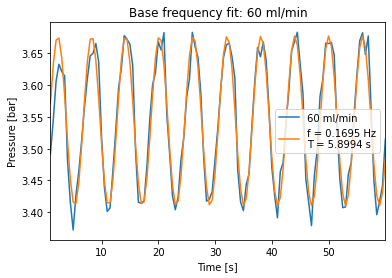

In [37]:
# Plot frequencies
plt.plot(time,values,label= dataset)
plt.plot(x,y, label=f"f = {freq_max:0.4f} Hz\nT = {1/freq_max:0.4f} s")
plt.legend(loc='center right')
plt.xlim(1,1+10/freq_max)
plt.xlabel("Time [s]")
plt.ylabel("Pressure [bar]")
plt.title(f"Base frequency fit: {dataset}")
if filename != None:
  plt.savefig(f"{path}/final-{filename}.png", dpi=300)
plt.show()
plt.show()

# <h1>Clearing folders</h1>

In [14]:
%rm -r data/*
%rm -r figures/*
%rm -r results/*

rm: cannot remove 'figures/*': No such file or directory
rm: cannot remove 'results/*': No such file or directory


In [15]:
!pwd

/content


In [16]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
